# Reliability classifiers 
## Overview 
todo:


## Dimensions for making the problem harder: 
1. ~Generating from lots of different shape, scale parameters. E.g. wearout_01 has shape=2.0, wearout_02 has shape=4.2, etc.~ 
2. ~Varying sample sizes. In particular, smaller sample sizes can be hard to classify~
4. ~Mixtures of distributions. E.g. many IM cases are actually IM+WO~
5. Adding noise (e.g. uniform distribution) 
6. Transforming to a multilabel classification problem 

## Next steps 
1. See data gen in 2023-04-17_nn-classifier-for-weibull-shape. Run simple models in that nb and check performance. Use same data gen method from that nb here. 

In [1]:
import sys
print(sys.executable)

/opt/conda/bin/python


In [2]:
import numpy as np
from scipy.stats import weibull_min, uniform
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)
from statsmodels.distributions.empirical_distribution import ECDF
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Set the random seed
np.random.seed(2023)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Problem params 

In [3]:
# Number of samples per class
n_samples_per_class = 10000

# Number of features
n_features = 50

# Scale parameter (constant for both classes)
scale_parameter = 2

# Shape parameters for the two classes
shape_parameter_infant = 0.8  # Values tried: 0.8, 1.0,
shape_parameter_wearout = 1.1  # Values tried: 2.0, 1.1

# Data generation

In [4]:
# Generate samples for class "infant mortality"
infant_mortality_features = weibull_min.rvs(shape_parameter_infant, scale=scale_parameter, size=(n_samples_per_class, n_features))
infant_mortality_labels = np.zeros(n_samples_per_class)


# Generate samples for class "wearout"
## Using Weibull distribution: 
wearout_features = weibull_min.rvs(shape_parameter_wearout, scale=scale_parameter, size=(n_samples_per_class, n_features))
wearout_labels = np.ones(n_samples_per_class)

## Using uniform distribution: 
uniform_features = uniform.rvs(loc=0, scale=scale_parameter*5, size=(n_samples_per_class, n_features))
uniform_labels = np.ones(n_samples_per_class)


# Combine all data
features = np.vstack((infant_mortality_features, wearout_features, uniform_features))
labels = np.concatenate((infant_mortality_labels, wearout_labels, uniform_labels))

In [5]:
# np.random.seed(25)  # todo: delete

# Shuffle the data
shuffle_idx = np.random.permutation(features.shape[0])
features = features[shuffle_idx]
labels = labels[shuffle_idx]

# Convert to a DataFrame for display 
df_data = pd.DataFrame(features)
df_data['class'] = labels
df_data['class_desc'] = df_data['class'].map({0: 'infant mortality', 1: 'wearout'})

In [6]:
df_data.shape

(30000, 52)

In [7]:
# Print the first few rows to check
df_data.head()

# Optionally save to a CSV file
# data.to_csv('weibull_data.csv', index=False)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,class,class_desc
0,3.333642,2.130109,2.380197,0.082428,0.695400,0.024406,1.224649,0.626377,0.018127,0.648051,...,2.566802,0.669108,1.286798,1.491562,6.958512,1.643321,0.110119,6.389068,0.0,infant mortality
1,1.018984,2.053225,4.055518,8.562901,1.936008,3.462903,3.370588,2.586449,9.852383,9.532488,...,3.356506,4.901398,2.320156,3.225032,0.784240,0.929690,3.947287,1.454586,1.0,wearout
2,6.920475,7.093516,4.480154,6.014292,5.251524,5.887233,8.543281,0.839331,4.446915,1.686797,...,0.940801,5.414938,4.846605,9.288860,5.403693,7.152535,5.136919,6.480683,1.0,wearout
3,1.081415,2.033824,2.675979,0.999703,5.993420,4.013154,5.048054,0.883713,9.124854,8.854685,...,3.066608,2.650058,8.022490,7.855076,0.356713,7.157692,3.648697,4.813003,1.0,wearout
4,0.795116,1.292300,2.842441,1.598803,7.340905,1.215592,0.447037,9.304268,0.456382,0.060420,...,3.257202,3.786947,10.684606,3.020919,0.006847,1.249115,4.667691,1.221080,0.0,infant mortality


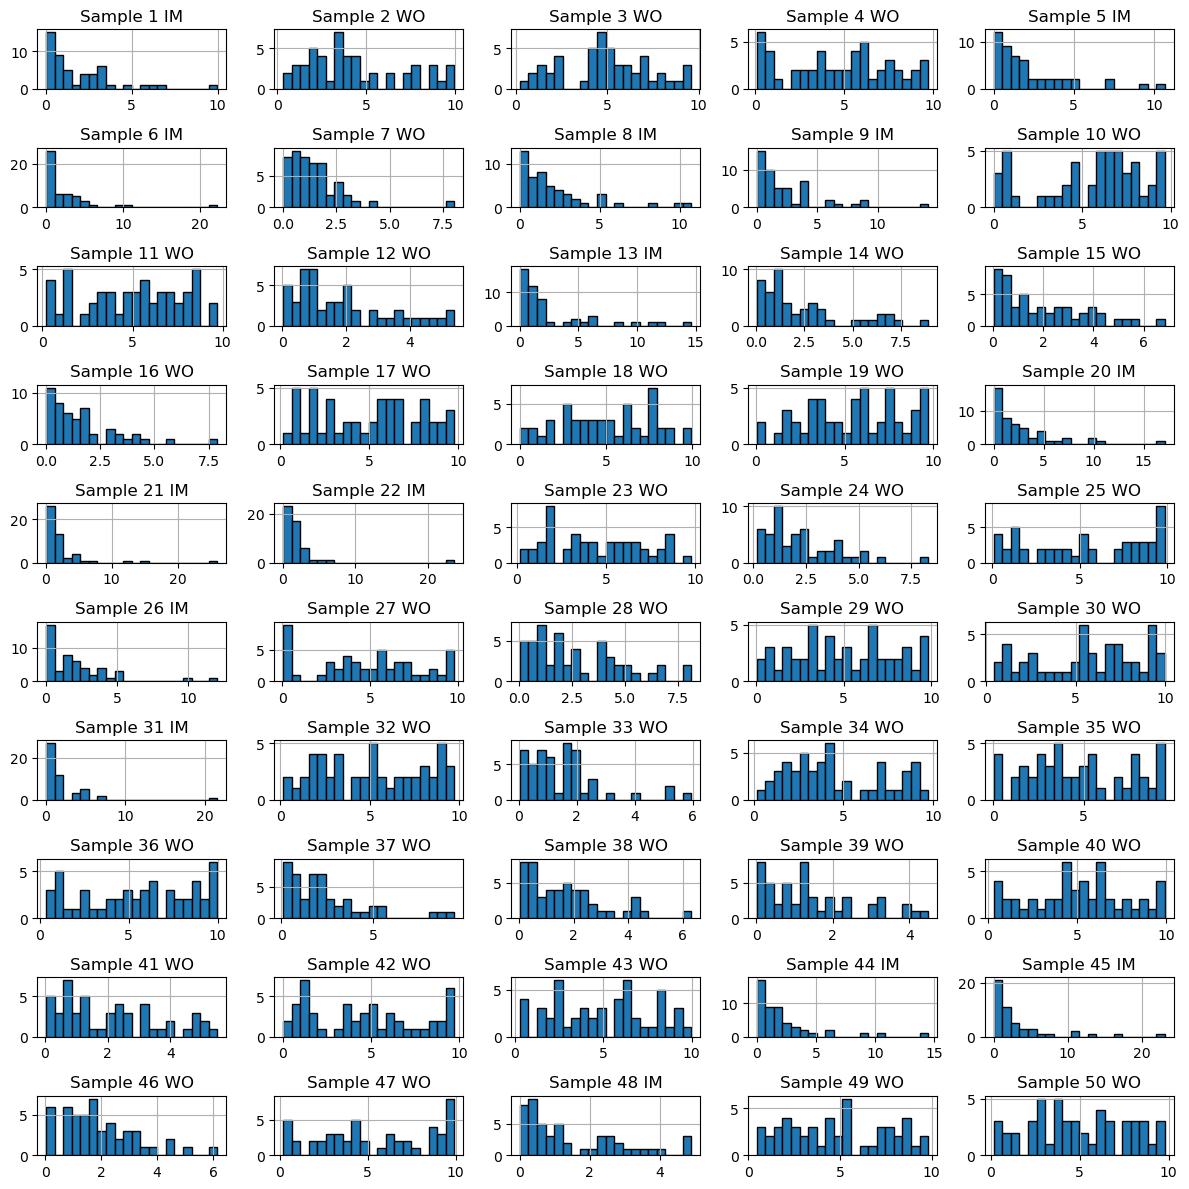

In [8]:
# Select specific rows for visualization (e.g., the 10th sample)
nrow = 10
ncol = 5
fig, axes = plt.subplots(nrow, ncol, figsize=(12,12))
ax_flat = axes.flatten()

for ax, sample_index in zip(ax_flat, list(range(nrow*ncol))): 
    selected_sample = features[sample_index]
    ax.hist(selected_sample, bins=20, edgecolor='black')
    ax.set_title(f'Sample {sample_index+1} {"IM" if labels[sample_index] == 0 else "WO"}')
    ax.grid(True)

plt.tight_layout()
plt.show();


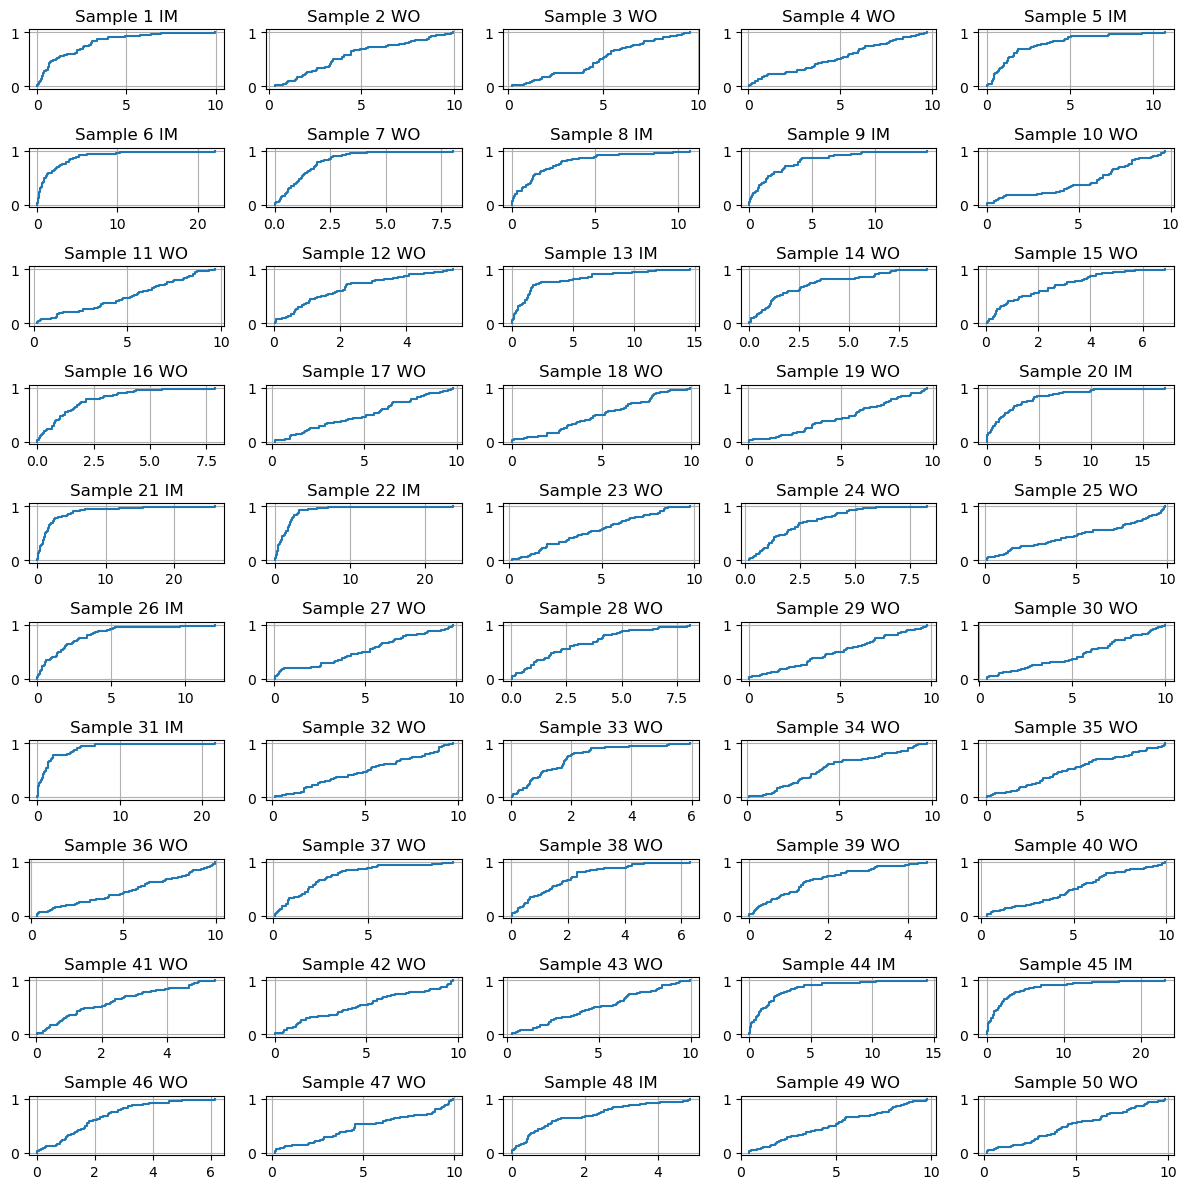

In [9]:
nrow = 10
ncol = 5
fig, axes = plt.subplots(nrow, ncol, figsize=(12,12))
ax_flat = axes.flatten()

for ax, sample_index in zip(ax_flat, list(range(nrow*ncol))): 
    selected_sample = features[sample_index]
    ecdf = ECDF(selected_sample)

    ax.step(ecdf.x, ecdf.y, where='post')
    ax.set_title(f'Sample {sample_index+1} {"IM" if labels[sample_index] == 0 else "WO"}')
    ax.grid(True)

plt.tight_layout()
plt.show();

# Train-test split 

In [10]:
X = df_data.iloc[:, :-2].values
X.shape
type(X)

(30000, 50)

numpy.ndarray

In [11]:
y = df_data.iloc[:, -2:-1].values.squeeze()
y.shape 
type(y)

(30000,)

numpy.ndarray

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2023)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=2023)

X_train.shape
X_valid.shape 
X_test.shape 

y_train.shape
y_valid.shape
y_test.shape


(19200, 50)

(4800, 50)

(6000, 50)

(19200,)

(4800,)

(6000,)

# Models

In [13]:
model_dict = {
    0: LogisticRegression(random_state=11), 
    1: RandomForestClassifier(random_state=11), 
    2: xgb.XGBClassifier(objective="binary:logistic", random_state=11)
}

# Training functions and evaluation functions

In [14]:
def train_model(model_num, X_train=X_train, y_train=y_train, X_valid=X_valid): 
    m = model_dict.get(model_num)
    m.fit(X_train, y_train)
    preds = m.predict(X_valid)
    return preds 

def evaluate_model(y, y_pred, model_desc=''): 
    cr = classification_report(y, y_pred)
    print(cr) 
    
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title(f'{model_desc}')
    plt.xlabel("predicted label")
    plt.ylabel("true label")
    plt.plot()
    

def train_eval_pipeline(model_num, _X_train=X_train, _y_train=y_train, _X_valid=X_valid, _y_valid=y_valid): 
    model_desc = model_dict.get(model_num)
    print(f'\n\nmodel: {model_desc}')
    preds_valid = train_model(model_num, _X_train, _y_train, _X_valid)
    evaluate_model(_y_valid, preds_valid, model_desc)

# Training and model selection




model: LogisticRegression(random_state=11)
              precision    recall  f1-score   support

         0.0       0.30      0.17      0.22      1659
         1.0       0.64      0.78      0.71      3141

    accuracy                           0.57      4800
   macro avg       0.47      0.48      0.46      4800
weighted avg       0.52      0.57      0.54      4800



model: RandomForestClassifier(random_state=11)
              precision    recall  f1-score   support

         0.0       0.85      0.78      0.81      1659
         1.0       0.89      0.93      0.91      3141

    accuracy                           0.88      4800
   macro avg       0.87      0.85      0.86      4800
weighted avg       0.88      0.88      0.88      4800



model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None

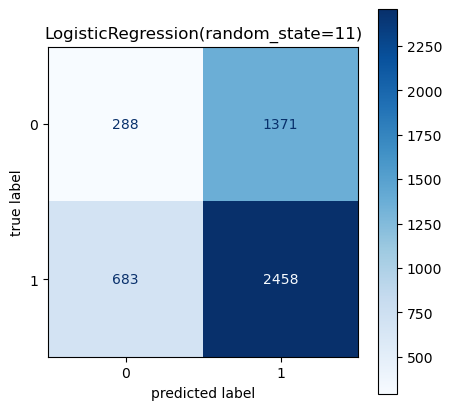

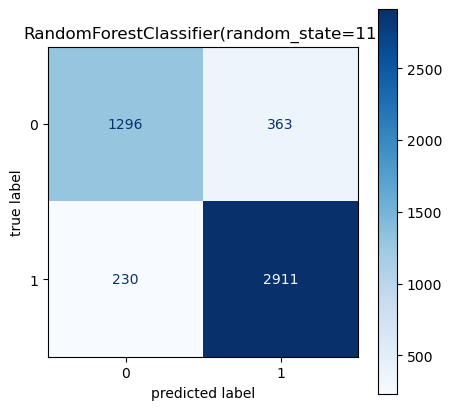

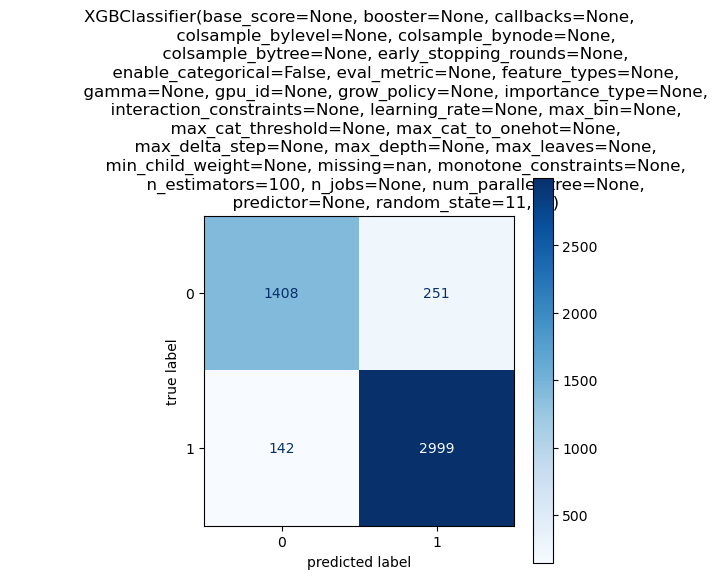

In [15]:
for model in model_dict.keys(): 
    train_eval_pipeline(model)

# Retraining selected model and running inference 

In [16]:
X_train_and_valid = np.concatenate((X_train, X_valid), axis=0)
y_train_and_valid = np.concatenate((y_train, y_valid), axis=0)



model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=11, ...)
              precision    recall  f1-score   support

         0.0       0.90      0.86      0.88      1972
         1.0       0.93      0.95      0.94      4028

    accuracy                           0.93      6000
   macro avg       0.92

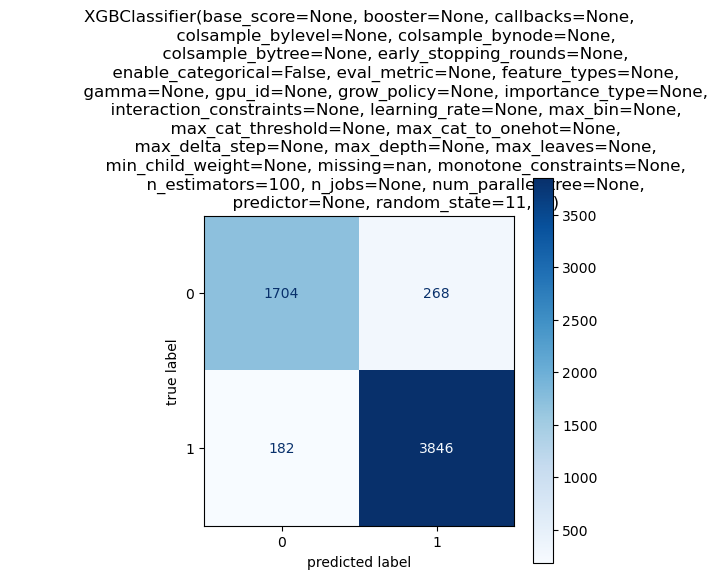

In [17]:
selected_model_num = 2
train_eval_pipeline(selected_model_num, X_train_and_valid, y_train_and_valid, X_test, y_test)